In [1]:
import lz 
from lz import *
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Using TensorFlow backend.


In [2]:
!wc -l /home/wangxinglu/prj/few-shot/data/imglst/img10k.test.smpl
!wc -l /home/wangxinglu/prj/few-shot/data/imglst/img10k.test.txt 
!wc -l /home/wangxinglu/prj/few-shot/data/imglst/img10k.test.twolevel

129678 /home/wangxinglu/prj/few-shot/data/imglst/img10k.test.smpl
568165 /home/wangxinglu/prj/few-shot/data/imglst/img10k.test.txt
568106 /home/wangxinglu/prj/few-shot/data/imglst/img10k.test.twolevel


In [11]:
def per_cls_acc(pred, lb):
    ### per cls acc
    timer = Timer()
    cnts, bounds = np.histogram(lb, bins=10000, range=(-0.5, 10000 - 0.5))
    print np.where(cnts == 0)
    cnts[cnts == 0] = 1
    assert len(cnts[cnts == 0]) == 0, 'val must have some samples'
    print(min(cnts))
    timer.toc()
    from sklearn.metrics import confusion_matrix

    conf = confusion_matrix(lb, pred, np.arange(0, 10000)).astype(float)
    timer.toc()

    plt.figure()
    plt.plot(np.diag(conf) / cnts)

    plt.figure()
    cnts, bounds, _ = plt.hist(lb, bins=10000, range=(-0.5, 10000 - 0.5))
    #     markerline, stemlines, baseline =plt.stem(cnts*np.diag(conf)/cnts)
    #     _=plt.setp(baseline, 'color', 'b')
    #     _=plt.setp(stemlines,'color','b')
    plt.plot(cnts * np.diag(conf) / cnts)
    timer.toc()
    return np.mean(lb == pred), np.nanmean(np.diag(conf) / cnts)
def load_fea(name, return_fc=False):
    import h5py, numpy as np
    f = h5py.File(name, 'r')

    orders = f['fcs'].keys()

    lbs = [f['lbs/' + l].value for l in orders]
    fcs = [f['fcs/' + l].value for l in orders]

    lb = np.concatenate(lbs, axis=-1)
    fc = np.concatenate(fcs, axis=-1)

    pred = np.argmax(fc, axis=0)
    pred = pred.reshape((pred.shape[-1],))
    lb = lb.reshape((lb.shape[-1],))

    f.close()
    if return_fc:
        return pred, lb, fc
    else:
        return pred, lb

In [6]:
%cd /home/wangxinglu/prj/few-shot/models/res101.img10k.longtail.flatten2/

/mnt/nfs1703/test/prj/few-shot/models/res101.img10k.longtail.flatten2


In [9]:
!ls -l

total 22206552
-rwxrwxrwx 1 wangxinglu wangxinglu         460 Sep 29 15:08 aiUCHncQQ5.png
-rw-rw-r-- 1 wangxinglu wangxinglu 22733739920 Oct 31 23:13 flatten2.h5
-rw-rw-r-- 1 wangxinglu wangxinglu     4326240 Oct 31 22:41 flatten3.h5
-rw-rw-r-- 1 wangxinglu wangxinglu        2318 Oct 31 22:56 load_model.py
-rwxrwxrwx 1 wangxinglu wangxinglu     1304856 Oct  4 06:30 log.txt
-rwxrwxrwx 1 wangxinglu wangxinglu      106053 Oct  2 11:26 model.yaml
lrwxrwxrwx 1 wangxinglu wangxinglu          27 Sep 29 14:30 res10k-flatten.yaml -> ../meta/res10k-flatten.yaml
lrwxrwxrwx 1 wangxinglu wangxinglu          17 Oct  3 09:25 run_parrots.py -> ../run_parrots.py
-rw-rw-r-- 1 wangxinglu wangxinglu        2740 Oct 31 22:47 session.bak.yaml
-rwxrwxrwx 1 wangxinglu wangxinglu        3717 Oct 31 22:39 session.yaml
drwxrwxrwx 1 wangxinglu wangxinglu        1174 Oct  4 08:15 snapshots
-rwxrwxrwx 1 wangxinglu wangxinglu           0 Oct  4 00:52 test


(array([], dtype=int64),)
3


(0.39411427203672023, 0.23016645153426263)

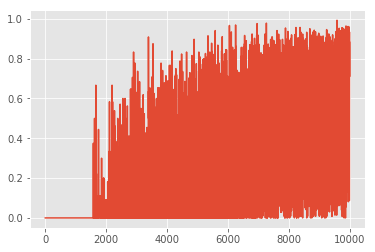

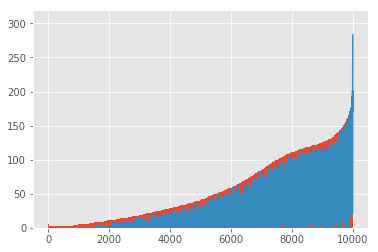

In [10]:
pred ,lb = load_fea('flatten2.h5')
per_cls_acc(pred,lb)

In [17]:
from utils import *
import utils
import matplotlib

matplotlib.style.use('ggplot')


def find_leaves(tree_, node, chk=True):
    res = []
    try:
        for node in nx.dfs_preorder_nodes(tree_, node):
            if tree_.node[node]['nchild'] != 0: continue
            res.append(node)
    except Exception as inst:
        print inst, 'wrong'
    return res


def find_child_recursive(tree_, node):
    res = set()
    for node in nx.dfs_preorder_nodes(tree_, node):
        res.add(node)
    return res


nimgs = unpickle('d.pkl')
nimgs = {k: len(v) for k, v in nimgs.iteritems()}
tree = nx.read_gml('tree.gml')
childs = find_leaves(tree, 'fall11')


def tag_tree(tree_):
    max_depth = 0
    all_depth = []
    all_nchild = []
    all_height=[]
    for node in nx.dfs_preorder_nodes(tree_, 'fall11'):
        depth = nx.shortest_path_length(tree_, "fall11", node)
        max_depth = max(depth, max_depth)
        all_depth.append(depth)
        nchild = len(list((tree_.successors(node))))
        all_nchild.append(nchild)

        height = max([nx.shortest_path_length(tree_, node, t) for t in find_leaves(tree_, node)])
        all_height.append(height)
        tree_.add_node(node, depth=depth, nchild=nchild, height=height)
    tree_.max_depth = max_depth
    tree_.all_depth = all_depth
    tree_.all_nchild = all_nchild
    tree_.all_height=all_height
    return tree_


tree = tag_tree(tree)


def edge_weight(inp):
    ni, nj = inp
    p1 = nx.shortest_path(tree, 'fall11', ni)
    p2 = nx.shortest_path(tree, 'fall11', nj)
    assert p1[0] == 'fall11'
    for ind, (t1, t2) in enumerate(zip(p1, p2)):
        if t1 != t2: break
    ind -= 1
    node = p1[ind]
    return tree.node[node]['height']


v = np.array(childs)
v = v[:4]
vl = v.shape[0]

inp = []
for i in range(vl):
    for j in range(i + 1, vl):
        inp.append([v[i], v[j]])
        # break
# pool = mp.Pool(128)
# wt = pool.map(edge_weight, inp)

In [15]:
ni, nj = inp[0]
p1 = nx.shortest_path(tree, 'fall11', ni)
p2 = nx.shortest_path(tree, 'fall11', nj)
p1,p2
assert p1[0] == 'fall11'
for ind, (t1, t2) in enumerate(zip(p1, p2)):
    if t1 != t2: break
ind -= 1
node = p1[ind]
tree.node[node]['height']

(['fall11', u'n09287968', u'n09433442', u'n09428293', u'n08596076'],
 ['fall11', u'n09287968', u'n09433442', u'n09428293', u'n09428628'])

1

(array([  3.49800000e+03,   3.64000000e+02,   1.69000000e+02,
          7.60000000e+01,   3.70000000e+01,   1.90000000e+01,
          1.10000000e+01,   4.00000000e+00,   2.00000000e+00,
          3.00000000e+00]),
 array([  1. ,   2.1,   3.2,   4.3,   5.4,   6.5,   7.6,   8.7,   9.8,
         10.9,  12. ]),
 <a list of 10 Patch objects>)

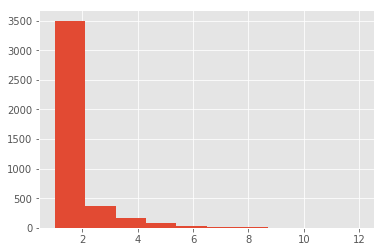

In [20]:
hs=(tree.all_height)
hs=np.array(hs)
hs=hs[hs!=0]
plt.hist(hs)